In [80]:
# Import stuff
import os
import scipy
import scipy.stats as stats

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
plt.set_cmap('viridis')
from matplotlib.lines import Line2D
import glob
import json
from scipy.stats import spearmanr
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from pingouin import mwu,kruskal, read_dataset
import seaborn as sns
import pymc3 as pm

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

<Figure size 432x288 with 0 Axes>

In [2]:
data_dir = '/media/bigdata/Abuzar_Data/AM12/AM12_4Tastes_191106_085215/'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dat.default_firing_params
# dat.firing_rate_params['type'] = 'baks'
# dat.firing_rate_params['baks_resolution'] = 10e-3

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()
dat.get_stft()
print(np.array(dat.spikes).shape)

All tastes have equal dimensions,concatenating and normalizing


/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/stft/stft_array`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/tables/leaf.py:410: PerformanceWarning: The Leaf ``/stft/amplitude_array`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in

(4, 30, 18, 7000)


(18, 120, 271)


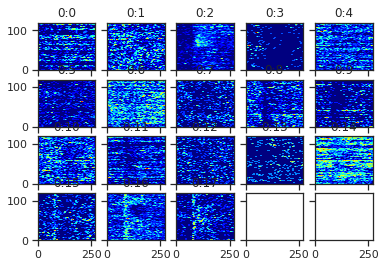

In [3]:
visualize.firing_overview(dat.all_normalized_firing);
print(dat.all_normalized_firing.shape)

In [4]:
print(dat.amplitude_array.shape)
print(dat.time_vec)

(4, 16, 30, 10, 5000)
[0.000e+00 1.000e-03 2.000e-03 ... 4.997e+00 4.998e+00 4.999e+00]


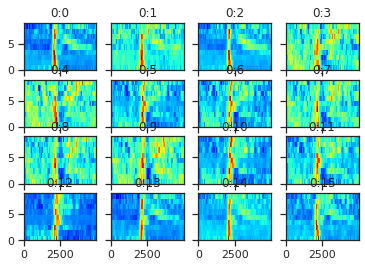

In [5]:
median_amplitude = np.median(dat.amplitude_array,axis=(0,2))
visualize.firing_overview(stats.zscore(median_amplitude,axis=-1));

(16, 10, 5000)
[array([ 0,  1,  2, 13, 14, 15]), array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])]
[ 0  1  2 13 14 15]


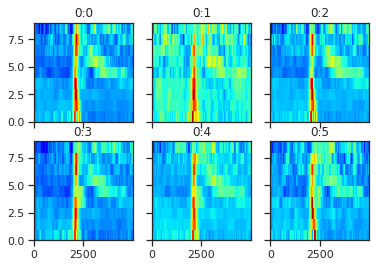

In [6]:
dat.get_lfp_electrodes()
print(median_amplitude.shape)
print(dat.lfp_region_electrodes)
gc_electrodes = dat.lfp_region_electrodes[[num for num,x in enumerate(dat.region_names) if x=='gc'][0]]
print(gc_electrodes)
visualize.firing_overview(stats.zscore(median_amplitude[gc_electrodes],axis=-1));

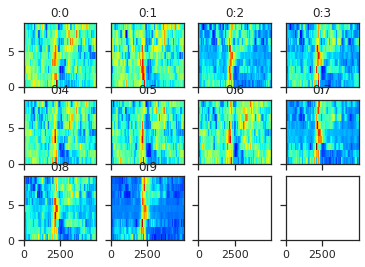

In [7]:
# If BLA present, plot BLA and GC spectra side-by-side
if 'bla' in dat.region_names:
    bla_electrodes = dat.lfp_region_electrodes[[num for num,x in enumerate(dat.region_names) if x=='bla'][0]]
    visualize.firing_overview(stats.zscore(median_amplitude[bla_electrodes],axis=-1));

(4, 30, 10, 2000)
(120, 10, 2000)
(10, 240000)


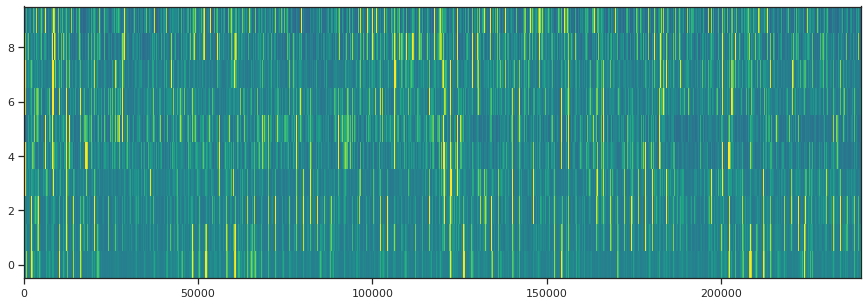

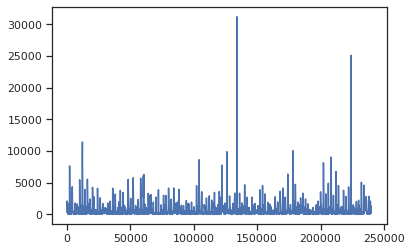

In [8]:
# Remove trials with artifacts
time_lims = [2000,4000]
channel = 0
this_amp_array = dat.amplitude_array[:,gc_electrodes[channel]]
# Cut by time_lims, smaller period means lower chance for artifacts
# This is dangerous in general though since pre and post stim time for stft is not properly accessible
this_amp_array = this_amp_array[...,time_lims[0]:time_lims[1]]
print(this_amp_array.shape)
this_amp_array_long = np.reshape(this_amp_array,(-1,*this_amp_array.shape[2:]))
print(this_amp_array_long.shape)
# Concatenate time trials along time axis for pca
this_amp_array_very_long = np.reshape(np.swapaxes(this_amp_array_long,0,1),(this_amp_array.shape[2],-1))
print(this_amp_array_very_long.shape)
plt.figure(figsize=(15,5))
thresh = 3
plt.imshow(stats.zscore(this_amp_array_very_long,axis=-1),aspect='auto',vmin = -thresh, vmax = thresh, origin='lower', cmap='viridis');
plt.figure()
plt.plot(this_amp_array_very_long[1])

In [9]:
# Find median absolute deivation for each frequency
# And remove trials with power higher than those
freq_med = np.median(this_amp_array_very_long,axis=-1)
MAD = np.median(np.abs((this_amp_array_very_long - freq_med[:,np.newaxis])),axis=-1)
print(MAD.shape)
print(freq_med)
print(MAD)

(10,)
[111.30520934 333.57699577 336.55950556 237.5281561  251.1533548
 155.21330131  71.21833494  55.24242152  53.61153425  51.91369224]
[104.12207882 255.01759649 259.41650197 179.37919492 172.05877719
 108.41110468  50.89310932  39.71127887  37.59133657  37.370481  ]


[ -5094.7987316  -12417.30282861 -12634.26559282  -8731.43158982
  -8351.78550468  -5265.34193244  -2473.43713101  -1930.32152219
  -1825.95529405  -1816.61035771]
18


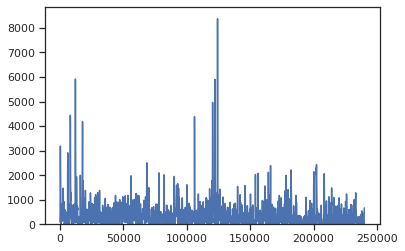

In [10]:
# Iterate through trials and remove ones outside thresholds
threshold = 50 # MADs from the median
lower_lim = freq_med - (threshold * MAD)
upper_lim = freq_med + (threshold * MAD)
freq = 4
plt.plot(this_amp_array_very_long[freq])
plt.ylim((0,upper_lim[freq]))

print(lower_lim)
outlier_trial_set = set()
for num, this_freq in enumerate(this_amp_array_long.swapaxes(0,1)):
#     num = 4
    this_freq = this_amp_array_long[:,num]
#     print(this_freq.shape)
    this_ll,this_ul = lower_lim[num],upper_lim[num]
#     print(this_ll,this_ul)
    outlier_inds = np.where(this_freq > this_ul)
    outlier_trial_set = outlier_trial_set.union(set(outlier_inds[0]))
#     print(len(outlier_inds[0]))
#     print(np.sort(np.unique(outlier_inds[0])))
print(len(outlier_trial_set))

(102, 10, 2000)
(10, 204000)


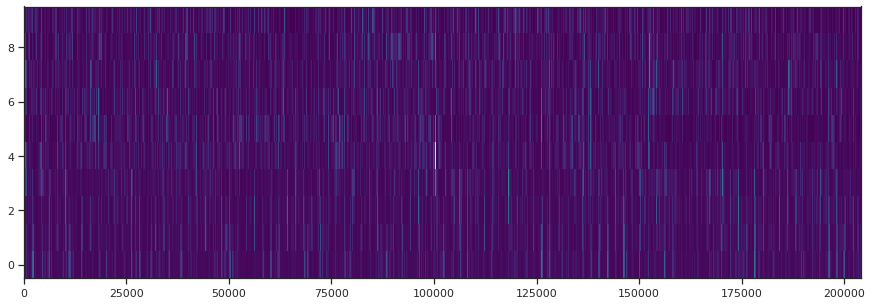

In [11]:
clean_trial_inds = [x for x in np.arange(this_amp_array_long.shape[0]) if x not in outlier_trial_set]
clean_this_amp_long = this_amp_array_long[np.array(clean_trial_inds)]
print(clean_this_amp_long.shape)
clean_amp_very_long = np.reshape(clean_this_amp_long.swapaxes(0,1),(len(dat.freq_vec),-1))
print(clean_amp_very_long.shape)
plt.figure(figsize=(15,5))
# thresh = 5
plt.imshow(stats.zscore(clean_amp_very_long,axis=-1),aspect='auto',origin='lower',cmap='viridis');

In [12]:
# Extract phase
phase_array = dat.phase_array
phase_array_long_temp = np.swapaxes(phase_array, 1,2)
phase_array_long = np.reshape(phase_array_long_temp, (-1,*phase_array_long_temp.shape[2:]))
phase_array_long_clean = phase_array_long[clean_trial_inds].swapaxes(0,1)
print(phase_array_long_clean.shape)

(16, 102, 10, 5000)


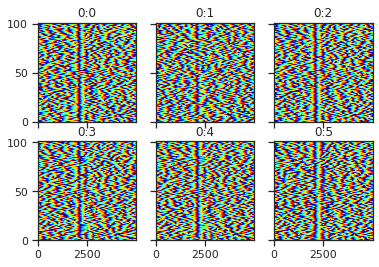

<Figure size 432x288 with 0 Axes>

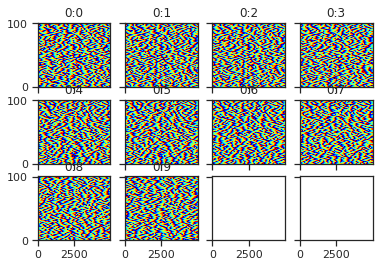

In [13]:
gc_phase = phase_array_long_clean[gc_electrodes]
bla_phase = phase_array_long_clean[bla_electrodes]
visualize.firing_overview(gc_phase[:,:,1]);
plt.figure()
visualize.firing_overview(bla_phase[:,:,1]);

(102, 10, 5000) (6, 102, 10, 5000)


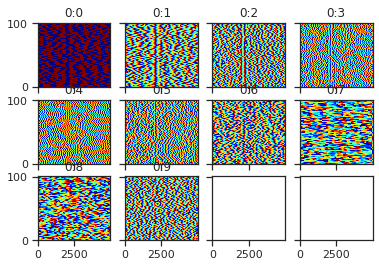

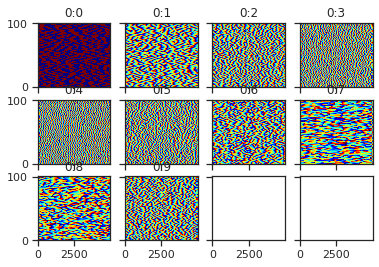

In [14]:
# Find representative channels for both regions
gc_med = np.median(gc_phase,axis=0)
gc_phase_diff = np.abs(gc_phase-gc_med)

print(gc_med.shape,gc_phase_diff.shape)
gc_min_err_chan = np.argmin(np.mean(gc_phase_diff,axis=(1,2,3)))
visualize.firing_overview(gc_phase[gc_min_err_chan].swapaxes(0,1));

bla_med = np.median(bla_phase,axis=0)
bla_phase_diff = np.abs(bla_phase-bla_med)

bla_min_err_chan = np.argmin(np.mean(bla_phase_diff,axis=(1,2,3)))
visualize.firing_overview(bla_phase[bla_min_err_chan].swapaxes(0,1));

-3.141592653589793 3.1415911281073714
(102, 10, 5000)
(102, 10, 5000)


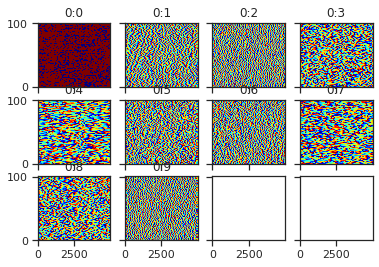

In [94]:
# Find single trial phase difference distribution
phase_diff_vec = np.exp(1.j*(-gc_phase[gc_min_err_chan] - bla_phase[bla_min_err_chan]))
# To wrap back into -pi -> pi range
phase_diff_angle = np.angle(phase_diff_vec)
print(np.min(phase_diff_angle,axis=None),np.max(phase_diff_angle,axis=None))
print(phase_diff.shape)
print(phase_diff_angle.shape)
visualize.firing_overview(phase_diff_angle.swapaxes(0,1));

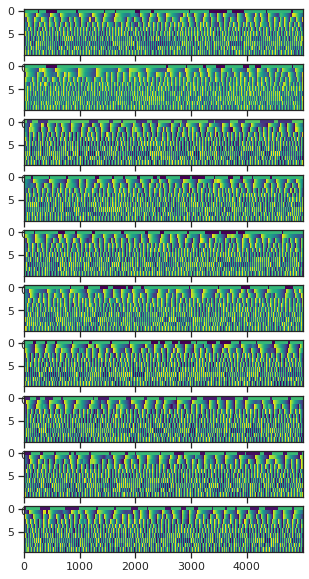

In [91]:
# Visualize changes on single trials
trial_count = 10
fig,ax = plt.subplots(trial_count,1,figsize=(5,trial_count))
for this_ax,this_dat in zip(ax,phase_diff_angle[:trial_count]):
    this_ax.imshow(stats.zscore(this_dat,axis=-1),aspect='auto',cmap='viridis')

In [52]:
# Rolling window phase coherence
window_size = 250 #ms
step_size = 25
total_time = phase_diff.shape[-1]
bin_count = int((total_time - window_size +1)/ step_size) + 1
bin_list = [np.array([0,window_size])+step for step in np.arange(bin_count)*step_size]
rolling_coherence = np.zeros((*phase_diff.shape[:-1],bin_count))
for num, bin_inds in enumerate(bin_list):
    rolling_coherence[...,num] = \
            np.abs(np.mean(phase_diff_vec[...,bin_inds[0]:bin_inds[1]],axis=-1))

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


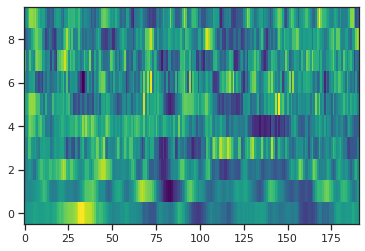

In [57]:
visualize.imshow(stats.zscore(np.mean(rolling_coherence,axis=0),axis=-1))
print(dat.freq_vec)

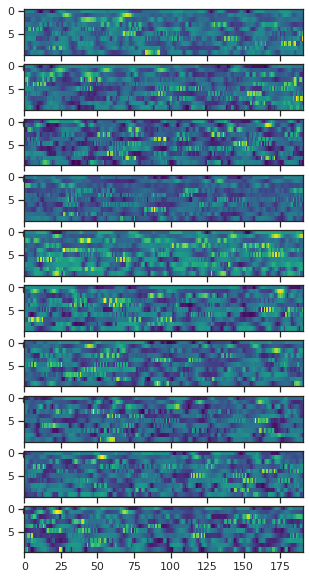

In [54]:
# Visualize rolling coherence on single trials
trial_count = 10
fig,ax = plt.subplots(trial_count,1,figsize=(5,trial_count))
for this_ax,this_dat in zip(ax,rolling_coherence[:trial_count]):
    this_ax.imshow(stats.zscore(this_dat,axis=-1),aspect='auto',cmap='viridis')

(29, 10, 5000)
[[2000 2250]
 [2250 2750]
 [2750 3500]]


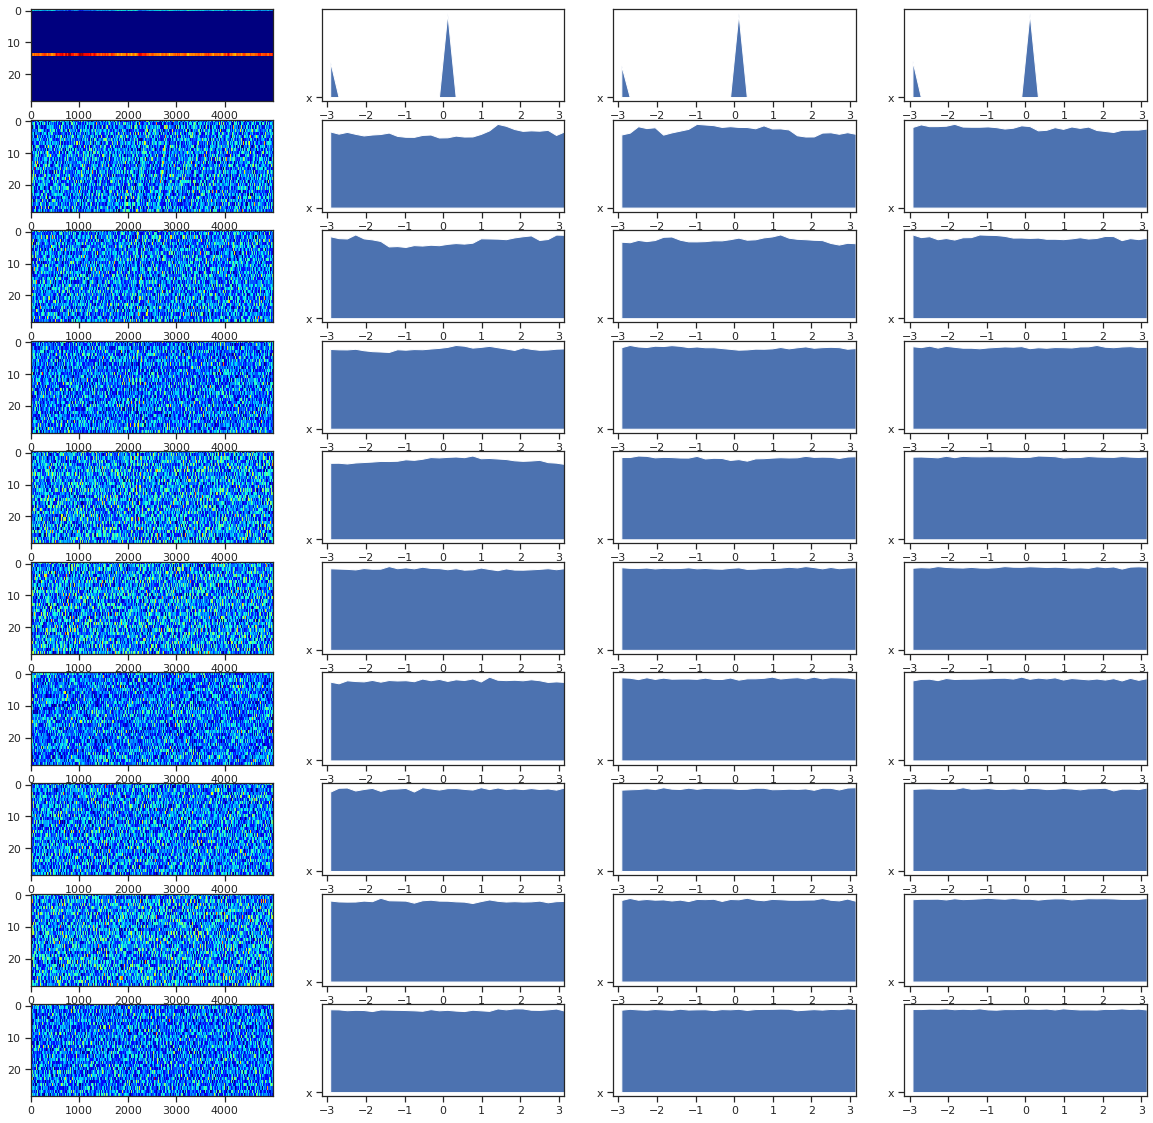

In [92]:
# Plot distribution of phase difference to make sure
# there's no zero lag coherence
phase_bins = np.linspace(-np.pi,np.pi,30)
phase_diff_hists = np.array([[\
                    np.histogram(freq,phase_bins)[0] \
                             for freq in time_bin] \
                    for time_bin in phase_diff_angle.T]).T
print(phase_diff_hists.shape)
fig,ax = plt.subplots(phase_diff_hists.shape[1],4,figsize=(20,20))
for this_ax,this_dat in zip(ax[:,0],phase_diff_hists.swapaxes(0,1)):
    this_ax.imshow(this_dat,aspect='auto',cmap='jet');

# Plot distributions for each epoch
time_periods = [[0,250],[250,750],[750,1500]]
time_inds = time_lims[0] + np.array(time_periods)
print(time_inds)

for ax_num, this_dat in enumerate(phase_diff_hists.swapaxes(0,1)):
    for num,this_epoch in enumerate(time_inds):
        ax[ax_num,1+num].fill_between(phase_bins[1:],np.sum(this_dat[...,this_epoch[0]:this_epoch[1]],axis=-1),'x');
        ax[ax_num,1+num].set_xlim(-np.pi,np.pi);

Although the average looks very non-descript, the fact that there are
VERY evident changes in the distribution of the phase differences
suggests that we should be able to use changepoints for SINGLE TRIALS

We should be able to use a Von Mises distribution (included in pymc3) for this

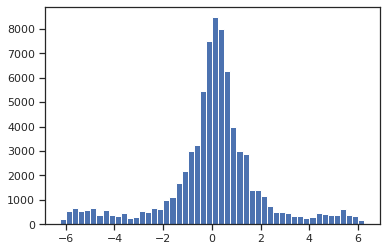

In [90]:
# Fit each histogram to von-mises distribution
# Test
epoch = 2
epoch_inds = time_inds[epoch]
test_dat = phase_diff[...,epoch_inds[0]:epoch_inds[1]]
band = 1
test_dat = test_dat[:,band]
plt.hist(test_dat.flatten(),bins = 50);

with pm.Model() as model:
    mu = pm.Uniform()

In [25]:
clean_dat_binned_long = dat_binned_long[clean_trial_inds]
print(clean_dat_binned_long.shape)
zscore_amp_long = stats.zscore(clean_this_amp_long,axis=-1)

(102, 7, 80)


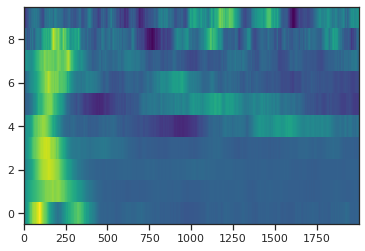

In [26]:
visualize.imshow(stats.zscore(np.median(clean_this_amp_long,axis=0),axis=-1))

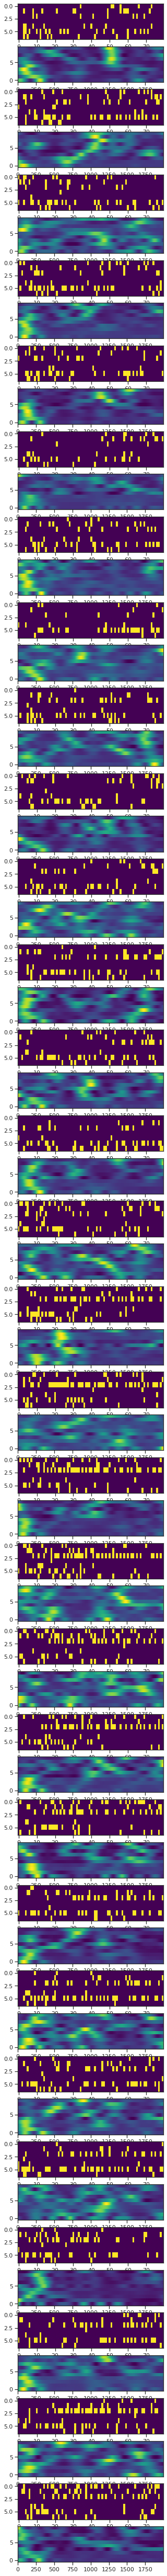

In [29]:
# Overlay raster with CDF of switchpoints
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num*2].imshow(clean_dat_binned_long[trial]>0,aspect = 'auto')
    ax[num*2+1].imshow(zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
#     ax[num,2].imshow(reduced_stft_long[trial],interpolation='nearest',aspect='auto',origin='lower')

In [31]:
this_bla_amp_array = dat.amplitude_array[:,bla_electrodes[channel]]
this_bla_amp_array = this_bla_amp_array[...,time_lims[0]:time_lims[1]]
print(this_bla_amp_array.shape)
bla_amp_long = np.reshape(this_bla_amp_array,(-1,*this_bla_amp_array.shape[2:]))
print(bla_amp_long.shape)
bla_amp_clean = bla_amp_long[clean_trial_inds]
print(bla_amp_clean.shape)
bla_zscore_amp_long = stats.zscore(bla_amp_clean,axis=-1)

(4, 30, 10, 2000)
(120, 10, 2000)
(102, 10, 2000)


In [32]:
dat.freq_vec

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18.])

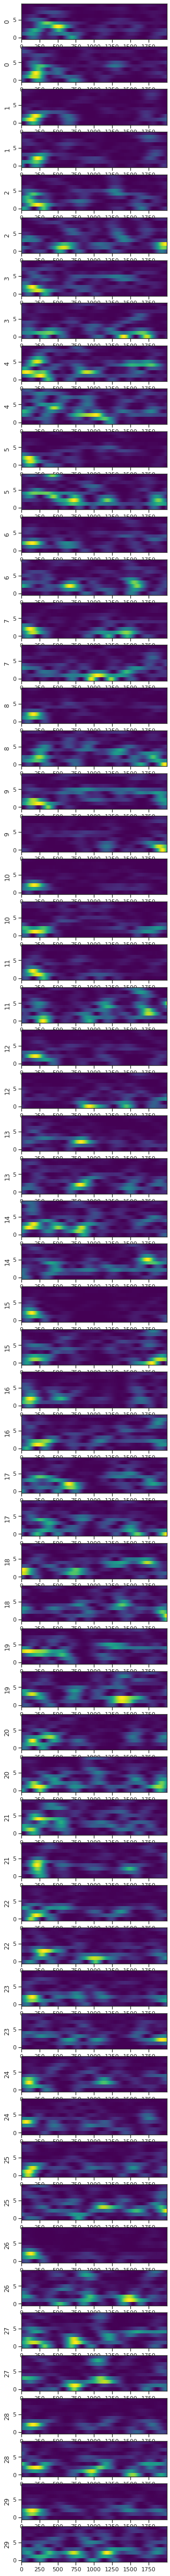

In [33]:
# Overlay raster with CDF of switchpoints
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
#     ax[num*2].imshow(zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
#     ax[num*2+1].imshow(bla_zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num*2].imshow(clean_this_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num*2+1].imshow(bla_amp_clean[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num*2].set_ylabel(num)
    ax[num*2+1].set_ylabel(num)
# ax[0,0].set_title('GC')
# ax[0,1].set_title('BLA')

Text(0.5, 1.0, 'BLA')

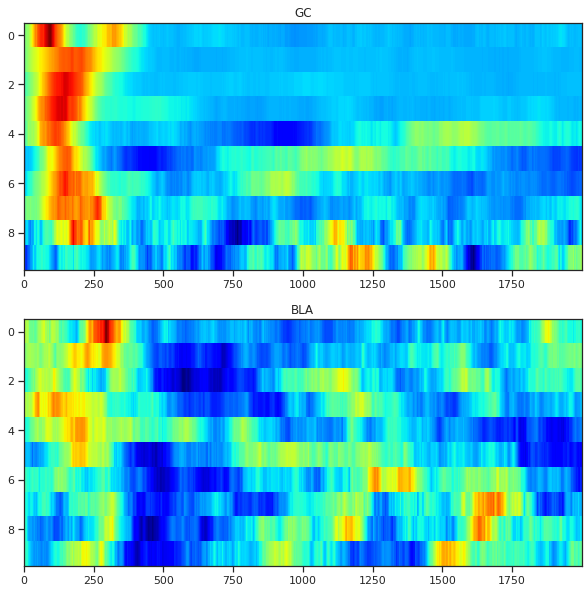

In [34]:
fig,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].imshow(stats.zscore(np.median(clean_this_amp_long,axis=0),axis=-1),aspect='auto',cmap='jet')
ax[1].imshow(stats.zscore(np.median(bla_amp_clean,axis=0),axis=-1),aspect='auto',cmap='jet')
ax[0].set_title('GC')
ax[1].set_title('BLA')

[1.         1.         1.         0.05904321 1.         1.
 1.         1.         1.        ]
[-1. -1. -1. -1. -1. -1. -1. -1. -1.]
[0.03005402 0.20835769 0.07023179 0.02744048 0.07253123 0.00606548
 0.04485018 0.02164737 0.01412874]
[1.         1.         1.         0.05904321 1.         1.
 1.         1.         1.        ]


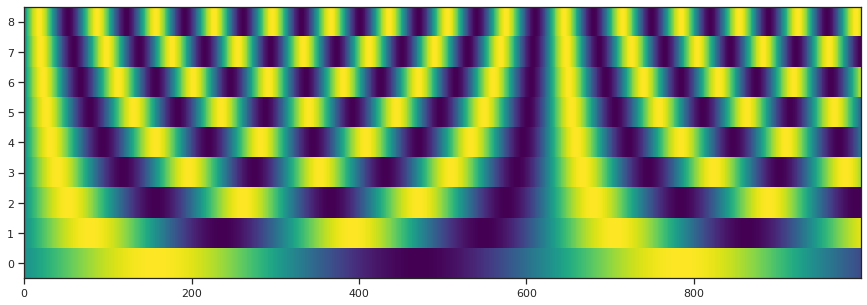

In [35]:
# Perform zero-lag cross-correlation on single trials and shuffled trials
# Use normalized cross-correlation to remove amplitude effects

def norm_zero_lag_xcorr(vec1, vec2):
    """
    Calculates normalized zero-lag cross correlation
    Returns a single number
    """
    auto_v1 = np.sum(vec1**2,axis=-1)
    auto_v2 = np.sum(vec2**2,axis=-1)
    xcorr = np.sum(vec1 * vec2,axis=-1)
    denom = np.sqrt(np.multiply(auto_v1,auto_v2))
    return np.divide(xcorr, denom)

# Testing function
x = np.linspace(0,10,1000)
y1 = np.array([np.sin(x*a) for a in range(1,10)])
y2 = y1/2
y3 = -y1
y4 = np.cos(x)
y5 = y2
y5[3] = np.ones(y5[3].shape)

plt.figure(figsize(15,5))
visualize.imshow(y1)

print(norm_zero_lag_xcorr(y1,y2))
print(norm_zero_lag_xcorr(y1,y3))
print(norm_zero_lag_xcorr(y1,y4))
print(norm_zero_lag_xcorr(y1,y5))

102
[89 27 35 39 16 80 37  5 80 84]
[87 95  7 55 60 80 19  3 83 38]
(102, 10)
(102, 10)


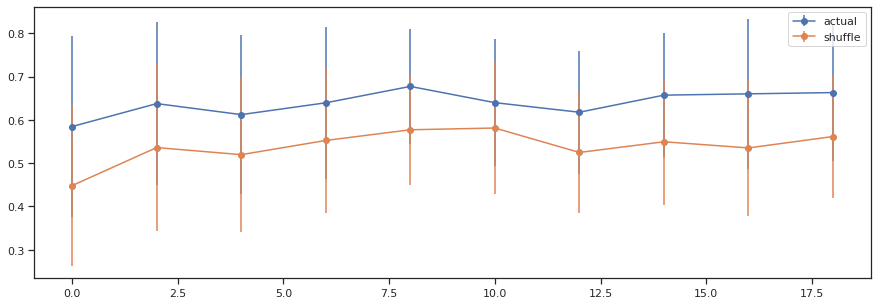

In [36]:
xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(clean_this_amp_long,bla_amp_clean)])
resamples = clean_this_amp_long.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(clean_this_amp_long[inds1],bla_amp_clean[inds2])])
mean_xcorrs = np.mean(xcorrs,axis=0)
std_xcorrs = np.std(xcorrs,axis=0)
mean_shuffle_xcorrs = np.mean(shuffled_xcorrs,axis=0)
std_shuffle_xcorrs = np.std(shuffled_xcorrs,axis=0)
plt.errorbar(dat.freq_vec,mean_xcorrs,std_xcorrs, label = 'actual',marker = 'o')
plt.errorbar(dat.freq_vec,mean_shuffle_xcorrs,std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
plt.legend();

print(xcorrs.shape)
print(shuffled_xcorrs.shape)


In [37]:
bla_amp_clean.shape

(102, 10, 2000)

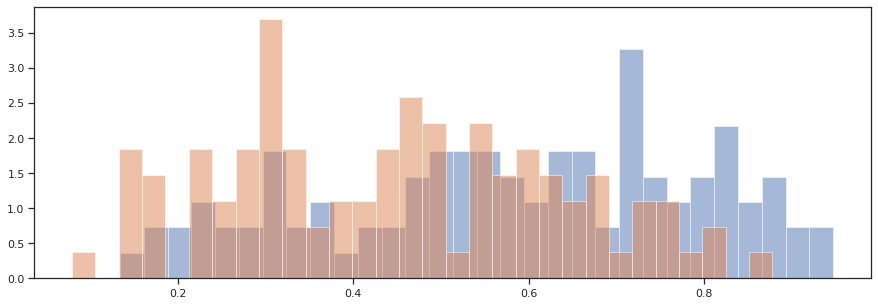

In [38]:
freq = 0
plt.hist(xcorrs[:,freq],30,alpha=0.5,density=True);
plt.hist(shuffled_xcorrs[:,freq],30,alpha=0.5,density=True);

In [39]:
# Perform xcorr between pairs of channels within BLA and GC for reference
channel2 = channel+1

this_gc_amp_array2 = dat.amplitude_array[:,gc_electrodes[channel2]]
this_gc_amp_array2 = this_gc_amp_array2[...,time_lims[0]:time_lims[1]]
print(this_gc_amp_array2.shape)
gc_amp_long2 = np.reshape(this_gc_amp_array2,(-1,*this_gc_amp_array2.shape[2:]))
print(gc_amp_long2.shape)
gc_amp_clean2 = gc_amp_long2[clean_trial_inds]
print(gc_amp_clean2.shape)

this_bla_amp_array2 = dat.amplitude_array[:,bla_electrodes[channel2]]
this_bla_amp_array2 = this_bla_amp_array2[...,time_lims[0]:time_lims[1]]
print(this_bla_amp_array2.shape)
bla_amp_long2 = np.reshape(this_bla_amp_array2,(-1,*this_bla_amp_array2.shape[2:]))
print(bla_amp_long2.shape)
bla_amp_clean2 = bla_amp_long2[clean_trial_inds]
print(bla_amp_clean2.shape)

(4, 30, 10, 2000)
(120, 10, 2000)
(102, 10, 2000)
(4, 30, 10, 2000)
(120, 10, 2000)
(102, 10, 2000)


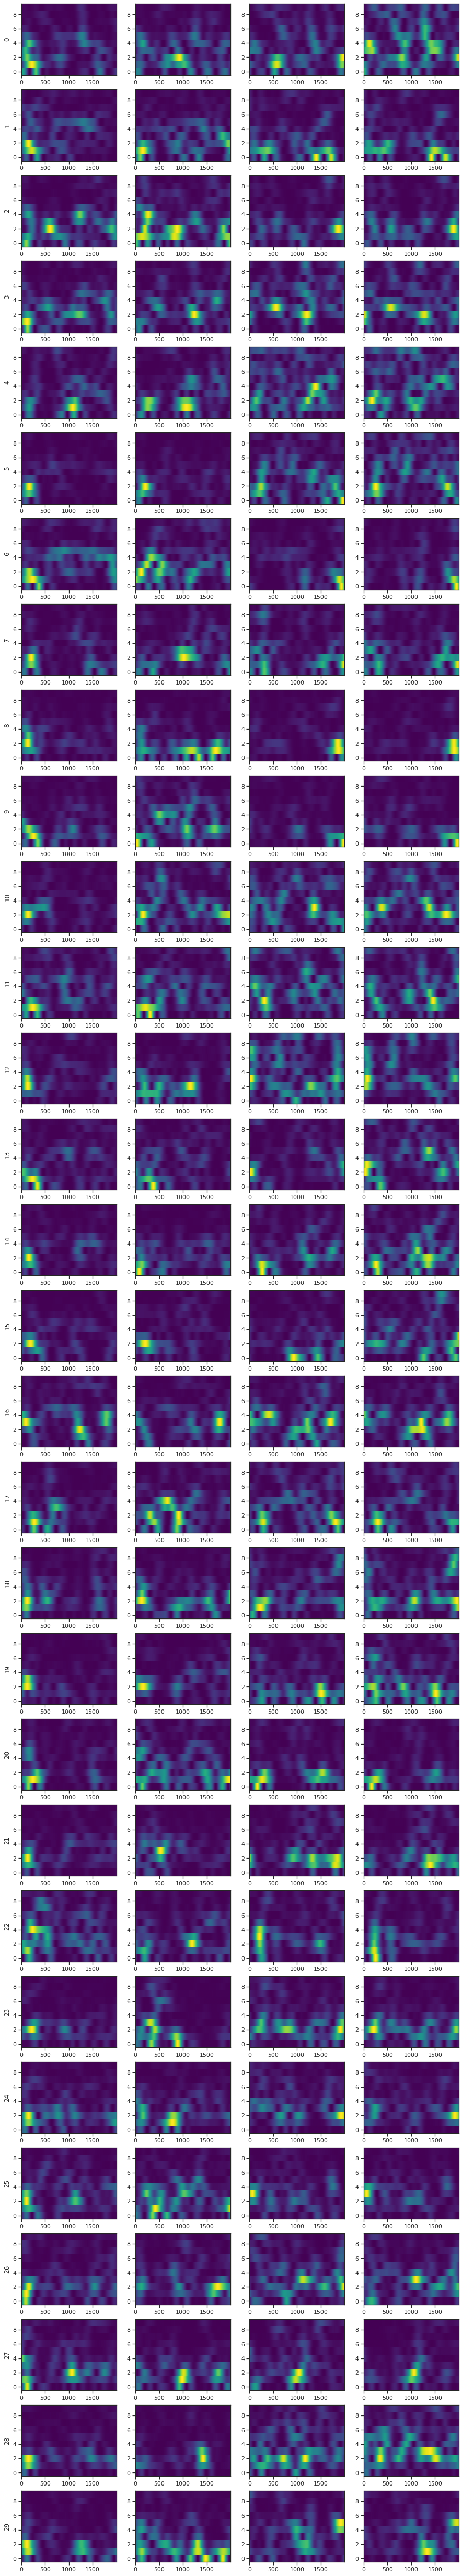

In [40]:
# Plot pairs of electrodes side by side to VISUALIZE similarity
# Overlay raster with CDF of switchpoints
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count, 4, figsize = (15,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(clean_this_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].imshow(gc_amp_clean2[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,2].imshow(bla_amp_clean[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,3].imshow(bla_amp_clean2[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,0].set_ylabel(num)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


102
[90  8  3 86 99 95 82 17 34 86]
[65 97 39 37 53 60 50 89 66 29]
102
[86 57 72 46 92 96 63 97 77 36]
[84 35 17  7 62 13 14  2 51 40]
(10,)
(102, 10)
(102, 10)


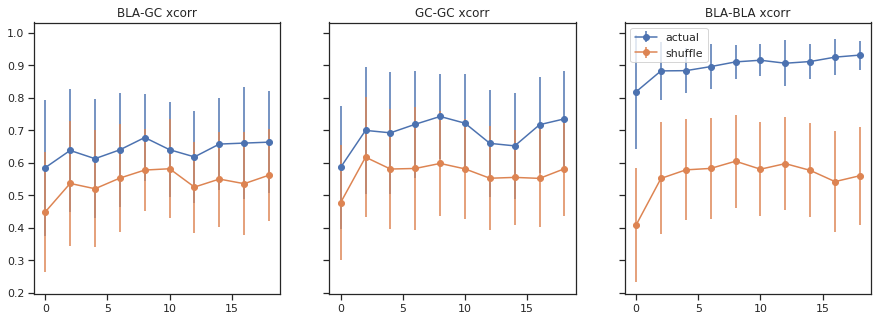

In [41]:
# Intra-GC xcorrs
gc_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(clean_this_amp_long,gc_amp_clean2)])
resamples = clean_this_amp_long.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
gc_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(clean_this_amp_long[inds1],gc_amp_clean2[inds2])])
gc_mean_xcorrs = np.mean(gc_xcorrs,axis=0)
gc_std_xcorrs = np.std(gc_xcorrs,axis=0)
gc_mean_shuffle_xcorrs = np.mean(gc_shuffled_xcorrs,axis=0)
gc_std_shuffle_xcorrs = np.std(gc_shuffled_xcorrs,axis=0)

# Intra BLA xcorrs
bla_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(bla_amp_clean,bla_amp_clean2)])
resamples = bla_amp_clean.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(bla_amp_clean.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(bla_amp_clean.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
bla_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(bla_amp_clean[inds1],bla_amp_clean2[inds2])])
bla_mean_xcorrs = np.mean(bla_xcorrs,axis=0)
bla_std_xcorrs = np.std(bla_xcorrs,axis=0)
bla_mean_shuffle_xcorrs = np.mean(bla_shuffled_xcorrs,axis=0)
bla_std_shuffle_xcorrs = np.std(bla_shuffled_xcorrs,axis=0)

# Plot cross-region with w/i region
fig,ax = plt.subplots(1,3,sharey=True, figsize = (15,5))
print(mean_xcorrs.shape)
ax[0].errorbar(dat.freq_vec,mean_xcorrs,std_xcorrs, label = 'actual',marker = 'o')
ax[0].errorbar(dat.freq_vec,mean_shuffle_xcorrs,std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[0].set_title('BLA-GC xcorr')
plt.legend();

ax[1].errorbar(dat.freq_vec,gc_mean_xcorrs,gc_std_xcorrs, label = 'actual',marker = 'o')
ax[1].errorbar(dat.freq_vec,gc_mean_shuffle_xcorrs,gc_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[1].set_title('GC-GC xcorr')
plt.legend();

ax[2].errorbar(dat.freq_vec,bla_mean_xcorrs,bla_std_xcorrs, label = 'actual',marker = 'o')
ax[2].errorbar(dat.freq_vec,bla_mean_shuffle_xcorrs,bla_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[2].set_title('BLA-BLA xcorr')
plt.legend();

print(gc_xcorrs.shape)
print(gc_shuffled_xcorrs.shape)

(9, 1000)


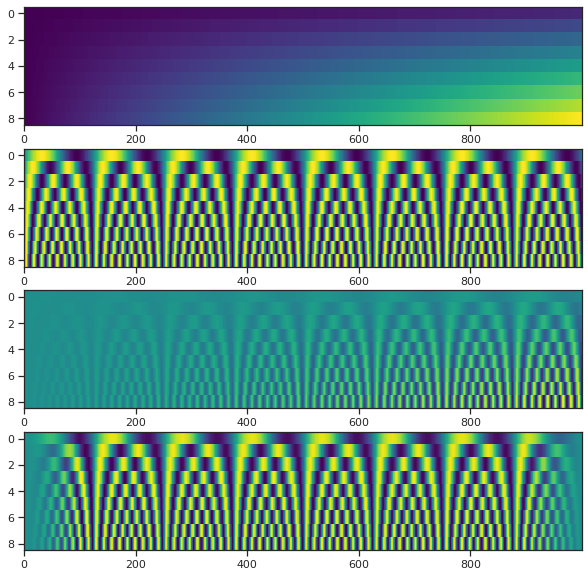

In [42]:
# Not that great
# It seems like we need to do rolling zscoring to capture local changes rather than over the entire trial

# Test signal
x_vec = np.linspace(0,50,1000)
x = np.array([x_vec*c for c in range(1,10)])
print(x.shape)
y = np.sin(x)
a = x/np.max(x)

y_a = a*y
fig,ax = plt.subplots(4,1,figsize=(10,10));
ax[0].imshow(x,aspect='auto')
ax[1].imshow(y,aspect='auto')
ax[2].imshow(y_a,aspect='auto')

def rolling_zscore(array, window_size):
    #array = y_a
    #window_size = 50
    out = np.zeros(array.shape)
    starts = np.arange((array.shape[-1] - window_size))
    inds = list(zip(starts,starts+window_size))
    for this_ind in inds:
        out[...,this_ind[0]:this_ind[1]] += stats.zscore(array[...,this_ind[0]:this_ind[1]],axis=-1)
    return out/window_size

ax[3].imshow(rolling_zscore(y_a,100),aspect='auto');

In [43]:
# # Not that great
# # It seems like we need to do rolling zscoring to capture local changes rather than over the entire trial
# # Gaussian weighted rolling z-score

# # Test signal
# x = np.linspace(0,50,1000)
# y = np.sin(x)
# change = 10
# a = x/np.max(x)

# y_a = a*y
# plt.plot(x,y,label = 'original')
# plt.plot(x,y_a,label = 'modified')

# # def rolling_zscore(vec, window_size):
# vec = y_a
# window_size = 50
# gauss_kern = scipy.signal.gaussian(window_size,window_size//6)
# plt.plot(x[:len(gauss_kern)],gauss_kern)
# plt.figure()
# plt.plot(x[:len(gauss_kern)],gauss_kern)
# out = np.zeros(vec.shape)
# starts = np.arange((vec.shape[-1] - window_size))
# inds = list(zip(starts,starts+window_size))
# for this_ind in tqdm(inds):
#     out[this_ind[0]:this_ind[1]] += (stats.zscore(y_a[this_ind[0]:this_ind[1]]))*gauss_kern
# out = out/window_size
# plt.figure()
# plt.plot(x,out,label = 'recovered')
# plt.legend()

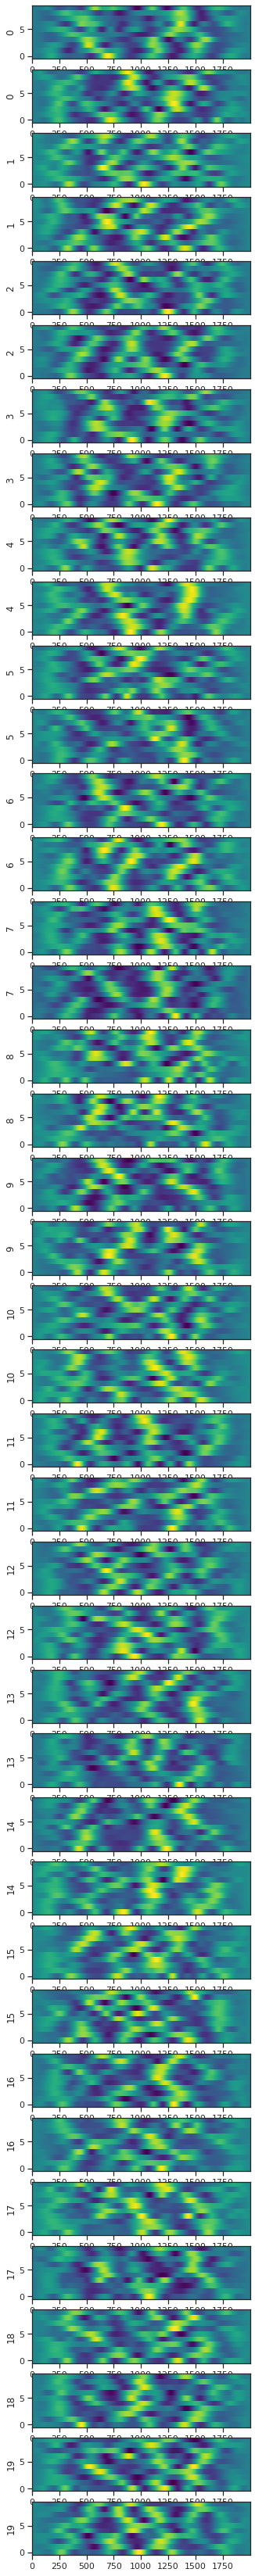

In [44]:
# Plot rolling zscored spectrograms
trial_count = 20
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))
rolling_size = 500

fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
#     ax[num*2].imshow(zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
#     ax[num*2+1].imshow(bla_zscore_amp_long[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num*2].imshow(rolling_zscore(clean_this_amp_long[trial],rolling_size),aspect='auto',origin='lower')
    ax[num*2+1].imshow(rolling_zscore(bla_amp_clean[trial],rolling_size),aspect='auto',origin='lower')
    ax[num*2].set_ylabel(num)
    ax[num*2+1].set_ylabel(num)
# ax[0,0].set_title('GC')
# ax[0,1].set_title('BLA')

In [45]:
# Perform rolling zscoring on spectrograms for both bla and gc
amp_array_long = np.swapaxes(dat.amplitude_array,1,2)
amp_array_long = np.reshape(amp_array_long,(-1,*amp_array_long.shape[2:]))
print(amp_array_long.shape)
channel = 0
gc_amp = amp_array_long[:,gc_electrodes[channel]]
gc_clean_amp = gc_amp[clean_trial_inds]
bla_amp = amp_array_long[:,bla_electrodes[channel]]
bla_clean_amp = bla_amp[clean_trial_inds]
print(gc_clean_amp.shape)

(120, 16, 10, 5000)
(102, 10, 5000)


In [46]:
window_size = 500
rzscore_gc_clean = np.array([rolling_zscore(x,window_size) for x in tqdm(gc_clean_amp)])
rzscore_bla_clean = np.array([rolling_zscore(x,window_size) for x in tqdm(bla_clean_amp)])
print(rzscore_gc_clean.shape)

100%|██████████| 102/102 [00:36<00:00,  2.78it/s]

(102, 10, 5000)


In [47]:
rzscore_gc_cut = rzscore_gc_clean[...,time_lims[0]:time_lims[1]]
rzscore_bla_cut = rzscore_bla_clean[...,time_lims[0]:time_lims[1]]

In [48]:
freq_vec = np.vectorize(np.int)(dat.freq_vec)[:-2]
freq_tick_labels = np.arange(freq_vec.min(),freq_vec.max(),3)
print(freq_tick_labels)
freq_ticks = np.linspace(0,len(freq_vec),len(freq_tick_labels))
print(freq_ticks)

[ 0  3  6  9 12]
[0. 2. 4. 6. 8.]


<Figure size 1080x360 with 0 Axes>

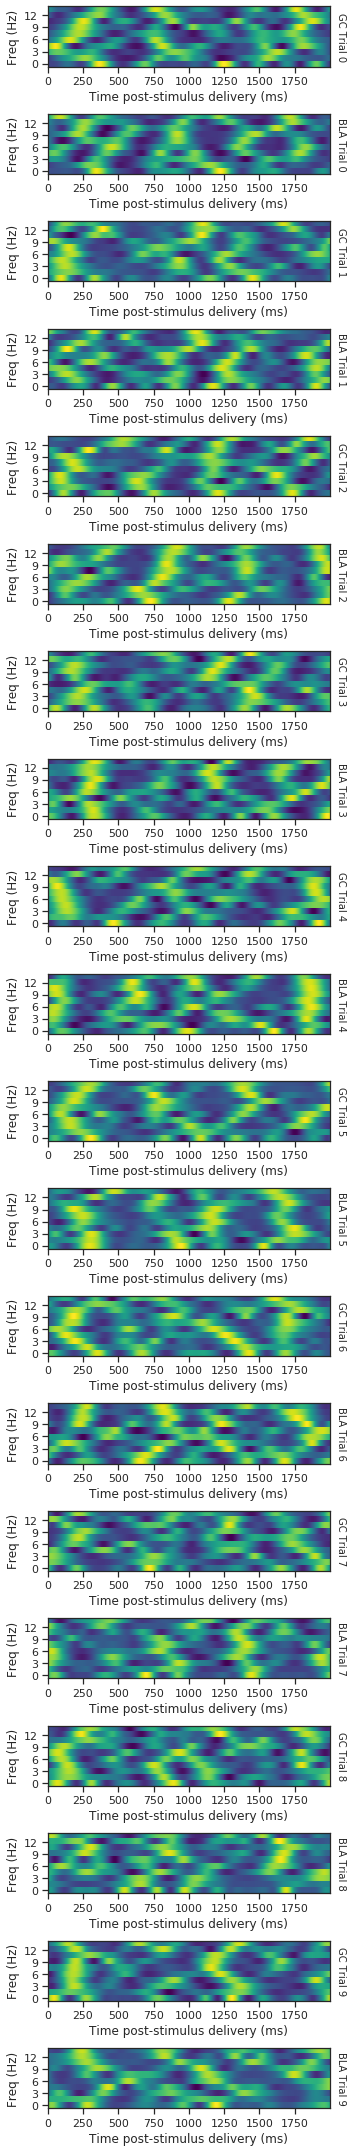

In [49]:
# Plot rolling zscored spectrograms
trial_count = 10

trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))
plt.set_cmap('viridis')
fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num*2].imshow(rzscore_gc_cut[trial],aspect='auto',origin='lower')
    ax[num*2+1].imshow(rzscore_bla_cut[trial],aspect='auto',origin='lower')
    
    ax[num*2].text(1.02,0.5,f'GC Trial {num}',rotation=270,verticalalignment='center', transform=ax[num*2].transAxes)
    ax[num*2+1].text(1.02,0.5,f'BLA Trial {num}',rotation=270,verticalalignment='center', transform=ax[num*2+1].transAxes)
    
    ax[num*2].set_yticks(ticks=freq_ticks)
    ax[num*2+1].set_yticks(ticks=freq_ticks)
    ax[num*2].set_yticklabels(labels = freq_tick_labels)
    ax[num*2+1].set_yticklabels(labels = freq_tick_labels)
    
    ax[num*2].set_ylabel('Freq (Hz)')
    ax[num*2+1].set_ylabel('Freq (Hz)')
    ax[num*2].set_xlabel('Time post-stimulus delivery (ms)')
    ax[num*2+1].set_xlabel('Time post-stimulus delivery (ms)')
plt.tight_layout()

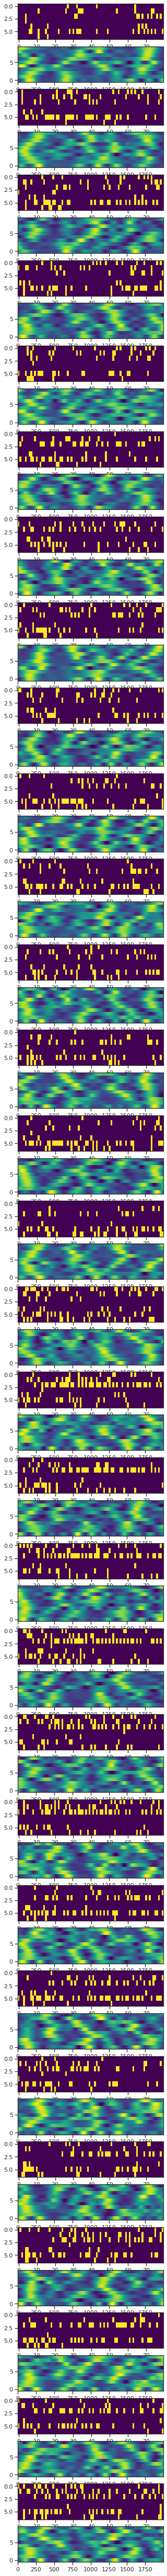

In [50]:
# Plot spikes with rolling zscored GC spectrograms
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(clean_dat_binned_long.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count*2, figsize = (5,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num*2].imshow(clean_dat_binned_long[trial]>0,aspect = 'auto')
    ax[num*2+1].imshow(rzscore_gc_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
#     ax[num,2].imshow(reduced_stft_long[trial],interpolation='nearest',aspect='auto',origin='lower')

[86 57 72 46 92 96 63 97 77 36]
[84 35 17  7 62 13 14  2 51 40]
(102, 10)
(102, 10)
[ 0  2  4  6  8 10 12 14 16 18]
[ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
  6.66666667  7.77777778  8.88888889 10.        ]


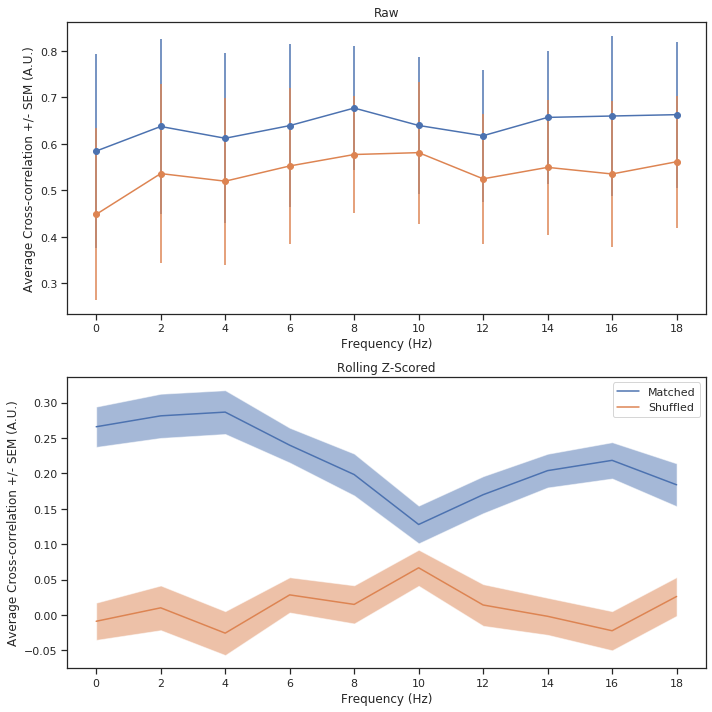

In [51]:
r_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(rzscore_gc_cut,rzscore_bla_cut)])
resamples = rzscore_gc_cut.shape[0]
r_inds1 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
r_inds2 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
r_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(rzscore_gc_cut[inds1],rzscore_bla_cut[inds2])])
r_mean_xcorrs = np.mean(r_xcorrs,axis=0)
r_std_xcorrs = np.std(r_xcorrs,axis=0)
r_sem_xcorrs = r_std_xcorrs/np.sqrt(r_xcorrs.shape[0])
r_mean_shuffle_xcorrs = np.mean(r_shuffled_xcorrs,axis=0)
r_std_shuffle_xcorrs = np.std(r_shuffled_xcorrs,axis=0)
r_sem_shuffle_xcorrs = r_std_shuffle_xcorrs/np.sqrt(r_shuffled_xcorrs.shape[0])

print(r_xcorrs.shape)
print(r_shuffled_xcorrs.shape)

freq_vec = np.vectorize(np.int)(dat.freq_vec)
freq_tick_labels = freq_vec
print(freq_tick_labels)
freq_ticks = np.linspace(0,len(freq_vec),len(freq_tick_labels))
print(freq_ticks)

fig,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].errorbar(dat.freq_vec,mean_xcorrs,std_xcorrs, label = 'Matched',marker = 'o')
ax[0].errorbar(dat.freq_vec,mean_shuffle_xcorrs,std_shuffle_xcorrs, label = 'Shuffled',marker = 'o')
ax[0].set_title('Raw')
ax[0].set_ylabel('Average Cross-correlation +/- SEM (A.U.)')
ax[0].set_xlabel('Frequency (Hz)')
# ax[1].errorbar(dat.freq_vec,r_mean_xcorrs,r_sem_xcorrs, label = 'Matched',marker = 'o')
# ax[1].errorbar(dat.freq_vec,r_mean_shuffle_xcorrs,r_sem_shuffle_xcorrs, label = 'Shuffled',marker = 'o')
ax[1].fill_between(dat.freq_vec,r_mean_xcorrs - r_sem_xcorrs, r_mean_xcorrs + r_sem_xcorrs,alpha = 0.5)
ax[1].fill_between(dat.freq_vec,r_mean_shuffle_xcorrs - r_sem_shuffle_xcorrs,r_mean_shuffle_xcorrs + r_sem_shuffle_xcorrs,alpha = 0.5)
ax[1].plot(dat.freq_vec,r_mean_xcorrs,label = 'Matched')
ax[1].plot(dat.freq_vec,r_mean_shuffle_xcorrs,label = 'Shuffled')
ax[1].set_title('Rolling Z-Scored')
ax[1].set_ylabel('Average Cross-correlation +/- SEM (A.U.)')
ax[1].set_xlabel('Frequency (Hz)')

ax[0].set_xticks(ticks=freq_tick_labels)
ax[1].set_xticks(ticks=freq_tick_labels)
ax[0].set_xticklabels(labels = freq_tick_labels)
ax[1].set_xticklabels(labels = freq_tick_labels)
plt.legend();
plt.tight_layout()

In [52]:
# Trials ranked by xcorrs from plotting
xcorr_sort = np.argsort(np.mean(r_xcorrs,axis=1))[::-1]

<Figure size 1080x360 with 0 Axes>

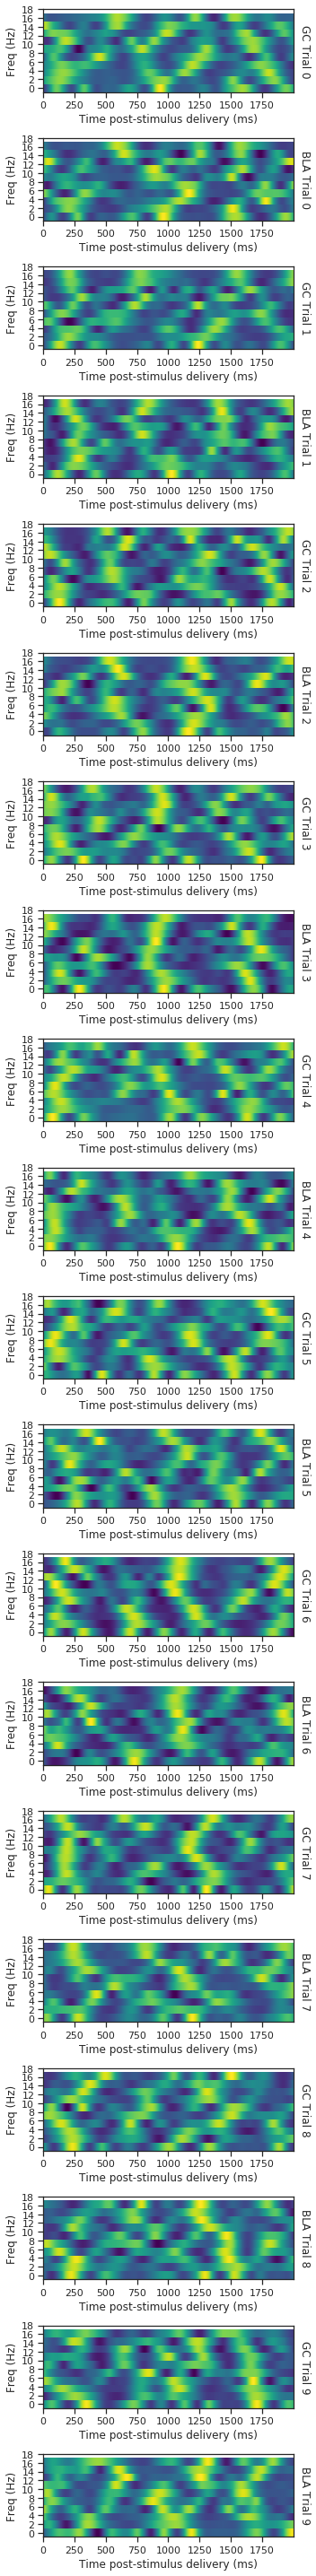

In [53]:
# Plot top 5 trials
# Plot rolling zscored spectrograms
trial_count = 10

trial_inds = xcorr_sort[:trial_count]
plt.set_cmap('viridis')
fig, ax = plt.subplots(trial_count*2, figsize = (5,4*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num*2].imshow(rzscore_gc_cut[trial],aspect='auto',origin='lower')
    ax[num*2+1].imshow(rzscore_bla_cut[trial],aspect='auto',origin='lower')
    
    ax[num*2].text(1.02,0.5,f'GC Trial {num}',rotation=270,verticalalignment='center', transform=ax[num*2].transAxes, size='large')
    ax[num*2+1].text(1.02,0.5,f'BLA Trial {num}',rotation=270,verticalalignment='center', transform=ax[num*2+1].transAxes, size='large')
    
    ax[num*2].set_yticks(ticks=freq_ticks)
    ax[num*2+1].set_yticks(ticks=freq_ticks)
    ax[num*2].set_yticklabels(labels = freq_tick_labels)
    ax[num*2+1].set_yticklabels(labels = freq_tick_labels)
    
    ax[num*2].set_ylabel('Freq (Hz)')
    ax[num*2+1].set_ylabel('Freq (Hz)')
    ax[num*2].set_xlabel('Time post-stimulus delivery (ms)')
    ax[num*2+1].set_xlabel('Time post-stimulus delivery (ms)')
plt.tight_layout()

In [54]:
# Perform xcorr between pairs of channels within BLA and GC for reference

gc_amp2 = amp_array_long[:,gc_electrodes[channel2]]
gc_clean_amp2 = gc_amp2[clean_trial_inds]
bla_amp2 = amp_array_long[:,bla_electrodes[channel2]]
bla_clean_amp2 = bla_amp2[clean_trial_inds]

rzscore_gc_clean2 = np.array([rolling_zscore(x,window_size) for x in tqdm(gc_clean_amp2)])
rzscore_bla_clean2 = np.array([rolling_zscore(x,window_size) for x in tqdm(bla_clean_amp2)])

100%|██████████| 102/102 [00:37<00:00,  2.74it/s]


In [55]:
rzscore_gc_cut2 = rzscore_gc_clean2[...,time_lims[0]:time_lims[1]]
rzscore_bla_cut2 = rzscore_bla_clean2[...,time_lims[0]:time_lims[1]]
print(rzscore_gc_clean2.shape)
print(rzscore_gc_cut2.shape)

(102, 10, 5000)
(102, 10, 2000)


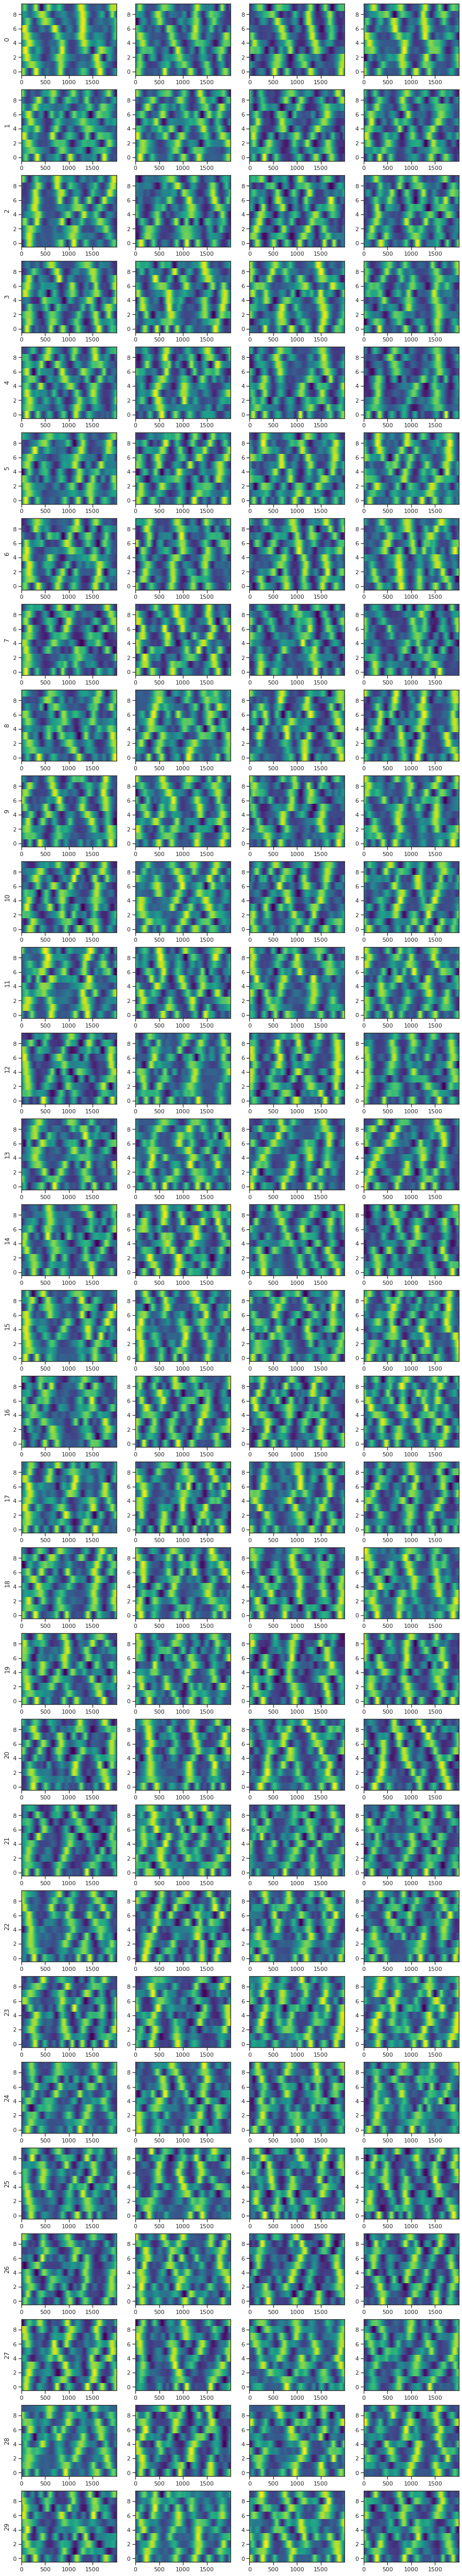

In [56]:
# Plot pairs of electrodes side by side to VISUALIZE similarity
# Overlay raster with CDF of switchpoints
trial_count = 30
trial_inds = np.sort(np.random.choice(np.arange(rzscore_gc_clean2.shape[0]),trial_count, replace = False))

fig, ax = plt.subplots(trial_count, 4, figsize = (15,3*trial_count))
for num,trial in enumerate(trial_inds):
    ax[num,0].imshow(rzscore_gc_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,1].imshow(rzscore_gc_cut2[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,2].imshow(rzscore_bla_cut[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,3].imshow(rzscore_bla_cut2[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[num,0].set_ylabel(num)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


102
[ 6 63 70 41 92 13  1 16 92 80]
[37 67 71 92 89 88 48 43 23 70]
102
[33 91 73 41 80 70 25 12 63 53]
[ 96 100  38  31  17  19  33  56  49   9]
(10,)
(102, 10)
(102, 10)


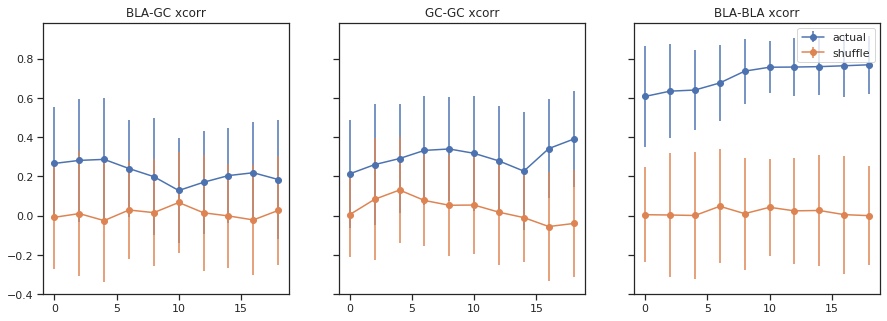

In [62]:
# Intra-GC xcorrs
r_gc_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(rzscore_gc_cut,rzscore_gc_cut2)])
resamples = rzscore_gc_cut.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
r_gc_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(rzscore_gc_cut[inds1],rzscore_gc_cut2[inds2])])
r_gc_mean_xcorrs = np.mean(r_gc_xcorrs,axis=0)
r_gc_std_xcorrs = np.std(r_gc_xcorrs,axis=0)
r_gc_mean_shuffle_xcorrs = np.mean(r_gc_shuffled_xcorrs,axis=0)
r_gc_std_shuffle_xcorrs = np.std(r_gc_shuffled_xcorrs,axis=0)

# Intra-BLA xcorrs
r_bla_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(rzscore_bla_cut,rzscore_bla_cut2)])
resamples = rzscore_bla_cut.shape[0]
print(resamples)
inds1 = np.random.choice(np.arange(rzscore_bla_cut.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(rzscore_bla_cut.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
r_bla_shuffled_xcorrs = np.array([norm_zero_lag_xcorr(v1,v2) \
                            for v1,v2 in zip(rzscore_bla_cut[inds1],rzscore_bla_cut2[inds2])])
r_bla_mean_xcorrs = np.mean(r_bla_xcorrs,axis=0)
r_bla_std_xcorrs = np.std(r_bla_xcorrs,axis=0)
r_bla_mean_shuffle_xcorrs = np.mean(r_bla_shuffled_xcorrs,axis=0)
r_bla_std_shuffle_xcorrs = np.std(r_bla_shuffled_xcorrs,axis=0)

# Plot cross-region with w/i region
fig,ax = plt.subplots(1,3,sharey=True, figsize = (15,5))
print(mean_xcorrs.shape)
ax[0].errorbar(dat.freq_vec,r_mean_xcorrs,r_std_xcorrs, label = 'actual',marker = 'o')
ax[0].errorbar(dat.freq_vec,r_mean_shuffle_xcorrs,r_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[0].set_title('BLA-GC xcorr')
plt.legend();

ax[1].errorbar(dat.freq_vec,r_gc_mean_xcorrs,r_gc_std_xcorrs, label = 'actual',marker = 'o')
ax[1].errorbar(dat.freq_vec,r_gc_mean_shuffle_xcorrs,r_gc_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[1].set_title('GC-GC xcorr')
plt.legend();


ax[2].errorbar(dat.freq_vec,r_bla_mean_xcorrs,r_bla_std_xcorrs, label = 'actual',marker = 'o')
ax[2].errorbar(dat.freq_vec,r_bla_mean_shuffle_xcorrs,r_bla_std_shuffle_xcorrs, label = 'shuffle',marker = 'o')
ax[2].set_title('BLA-BLA xcorr')
plt.legend();

print(gc_xcorrs.shape)
print(gc_shuffled_xcorrs.shape)



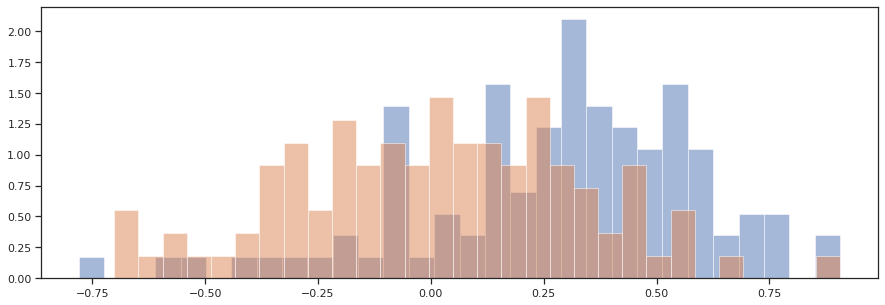

In [58]:
freq = 1
plt.hist(r_xcorrs[:,freq],30,alpha=0.5,density=True);
plt.hist(r_shuffled_xcorrs[:,freq],30,alpha=0.5,density=True);

In [59]:
# Perform Kruskal-Wallis to check for difference b/w actual and shuffle (in both raw and r-zscored)

# Raw
actual_inds = np.array(list(np.ndindex(xcorrs.shape)))
print(f'actual_inds_shape : {actual_inds.shape}')
xcorr_frame = pd.DataFrame({
                    'trials':actual_inds[:,0],
                    'freqs' : actual_inds[:,1],
                    'corr' : xcorrs.flatten(),
                    'class': ['actual']*actual_inds.shape[0]
})
shuffle_inds = np.array(list(np.ndindex(shuffled_xcorrs.shape)))
xcorr_frame = xcorr_frame.append(pd.DataFrame({
                    'trials': shuffle_inds[:,0],
                    'freqs' : shuffle_inds[:,1],
                    'corr' : shuffled_xcorrs.flatten(),
                    'class': ['shuffle']*shuffle_inds.shape[0]
}))
# print(xcorr_frame)
print(kruskal(data=xcorr_frame, dv='corr', between='class'))

## Also perform pairwise Mann-Whitney Test
mwu_tests = pd.concat([mwu(x, y, tail='two-sided') for x,y in zip(xcorrs.T, shuffled_xcorrs.T)])
print(mwu_tests)

actual_inds_shape : (1020, 2)
        Source  ddof1        H         p-unc
Kruskal  class      1  177.127  2.054305e-40
      U-val       tail         p-val    RBC   CLES
MWU  7132.5  two-sided  4.695527e-06 -0.371  0.686
MWU  6826.5  two-sided  1.170994e-04 -0.312  0.656
MWU  6688.5  two-sided  4.238266e-04 -0.286  0.643
MWU  6648.5  two-sided  6.037921e-04 -0.278  0.639
MWU  7331.5  two-sided  4.418609e-07 -0.409  0.705
MWU  6267.5  two-sided  1.153120e-02 -0.205  0.602
MWU  7040.5  two-sided  1.302246e-05 -0.353  0.677
MWU  7290.5  two-sided  7.318090e-07 -0.401  0.701
MWU  7506.5  two-sided  4.627053e-08 -0.443  0.721
MWU  7114.5  two-sided  5.753392e-06 -0.368  0.684


In [60]:
# ==============================================================#
# Rolling z-score
r_actual_inds = np.array(list(np.ndindex(r_xcorrs.shape)))
print(r_actual_inds.shape)
rz_xcorr_frame = pd.DataFrame({
                    'trials':r_actual_inds[:,0],
                    'freqs' : r_actual_inds[:,1],
                    'corr' : r_xcorrs.flatten(),
                    'class': ['actual']*r_actual_inds.shape[0]
})
r_shuffle_inds = np.array(list(np.ndindex(r_shuffled_xcorrs.shape)))
rz_xcorr_frame = rz_xcorr_frame.append(pd.DataFrame({
                    'trials': r_shuffle_inds[:,0],
                    'freqs' : r_shuffle_inds[:,1],
                    'corr' : r_shuffled_xcorrs.flatten(),
                    'class': ['shuffle']*r_shuffle_inds.shape[0]
}))
# print(rz_xcorr_frame)
print(kruskal(data=rz_xcorr_frame, dv='corr', between='class'))

## Also perform pairwise Mann-Whitney Test
mwu_tests = pd.concat([mwu(x, y, tail='two-sided') for x,y in zip(r_xcorrs.T, r_shuffled_xcorrs.T)])
print(mwu_tests)

(1020, 2)
        Source  ddof1        H         p-unc
Kruskal  class      1  244.642  3.823731e-55
      U-val       tail         p-val    RBC   CLES
MWU  7884.5  two-sided  1.995469e-10 -0.516  0.758
MWU  7706.5  two-sided  2.859377e-09 -0.481  0.741
MWU  7970.5  two-sided  5.179569e-11 -0.532  0.766
MWU  7515.5  two-sided  4.101535e-08 -0.445  0.722
MWU  7138.5  two-sided  4.386370e-06 -0.372  0.686
MWU  5983.5  two-sided  6.395009e-02 -0.150  0.575
MWU  6657.5  two-sided  5.579924e-04 -0.280  0.640
MWU  7595.5  two-sided  1.377336e-08 -0.460  0.730
MWU  7571.5  two-sided  1.917827e-08 -0.455  0.728
MWU  6733.5  two-sided  2.817529e-04 -0.294  0.647


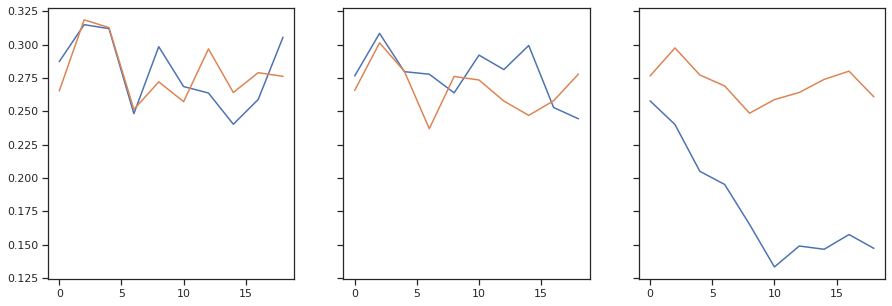

In [61]:
# Calculate effect-size of difference for each frequency
# This will allow us to plot effect size distributions for all 
# electrode pairs

# Plot variance to visualize how different they are for Cohen's D SD pooling
fig,ax = plt.subplots(1,3,sharey=True, figsize = (15,5))
ax[0].plot(dat.freq_vec,r_std_xcorrs)
ax[0].plot(dat.freq_vec,r_std_shuffle_xcorrs)

ax[1].plot(dat.freq_vec,r_gc_std_xcorrs)
ax[1].plot(dat.freq_vec,r_gc_std_shuffle_xcorrs)

ax[2].plot(dat.freq_vec,r_bla_std_xcorrs)
ax[2].plot(dat.freq_vec,r_bla_std_shuffle_xcorrs)

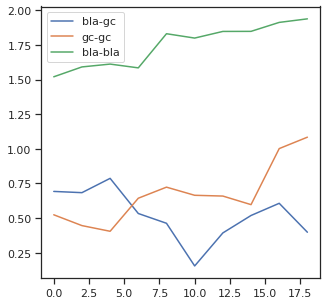

In [69]:
# We'll ignore testing variance for now
pooled_sd_xcorr = np.sqrt(np.mean(r_std_xcorrs**2 + r_std_shuffle_xcorrs**2))
pooled_gc_sd_xcorr = np.sqrt(np.mean(r_gc_std_xcorrs**2 + r_gc_std_shuffle_xcorrs**2))
pooled_bla_sd_xcorr = np.sqrt(np.mean(r_bla_std_xcorrs**2 + r_bla_std_shuffle_xcorrs**2))

xcorr_effect = np.abs(r_mean_xcorrs - r_mean_shuffle_xcorrs)/pooled_sd_xcorr
gc_xcorr_effect = np.abs(r_gc_mean_xcorrs - r_gc_mean_shuffle_xcorrs)/pooled_sd_xcorr
bla_xcorr_effect = np.abs(r_bla_mean_xcorrs - r_bla_mean_shuffle_xcorrs)/pooled_sd_xcorr

plt.figure(figsize=(5,5))
plt.plot(dat.freq_vec,xcorr_effect,label='bla-gc')
plt.plot(dat.freq_vec,gc_xcorr_effect,label='gc-gc')
plt.plot(dat.freq_vec,bla_xcorr_effect,label='bla-bla')
plt.legend();

In [ ]:
print(clean_this_amp_long.shape)
print(np.array(np.split(clean_this_amp_long,4,axis=-1)).shape)

In [ ]:
# Chop trial into 500ms bins and perform xcorr on each bin separately
splits = clean_this_amp_long.shape[-1]//500
gc_amp_split = np.array(np.split(clean_this_amp_long,splits,axis=-1))
bla_amp_split = np.array(np.split(bla_amp_clean,splits,axis=-1))
xcorrs = np.array([[norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(this_gc,this_bla)]\
                 for this_gc,this_bla in zip(gc_amp_split,bla_amp_split)])
print(xcorrs.shape)

resamples = 1000
inds1 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(clean_this_amp_long.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
shuffled_xcorrs = np.array([[norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(this_gc,this_bla)]\
                 for this_gc,this_bla in zip(gc_amp_split[:,inds1],bla_amp_split[:,inds2])])

mean_xcorrs = np.mean(xcorrs,axis=1)
std_xcorrs = np.std(xcorrs,axis=1)
mean_shuffle_xcorrs = np.mean(shuffled_xcorrs,axis=1)
std_shuffle_xcorrs = np.std(shuffled_xcorrs,axis=1)

fig,ax = plt.subplots(1,mean_xcorrs.shape[0],figsize = (15,5),sharey=True)
for this_bin in np.arange(mean_xcorrs.shape[0]):
    ax[this_bin].errorbar(dat.freq_vec,mean_xcorrs[this_bin],std_xcorrs[this_bin], label = 'actual',marker = 'o')
    ax[this_bin].errorbar(dat.freq_vec,mean_shuffle_xcorrs[this_bin],std_shuffle_xcorrs[this_bin], label = 'shuffle',marker = 'o')
plt.legend();

# Plot mean difference for each bin
mean_diff = mean_xcorrs - mean_shuffle_xcorrs
inds = np.array(list(np.ndindex(mean_diff.shape)))
mean_diff_frame = pd.DataFrame({
                    'bin' : inds[:,0],
                    'freq' : inds[:,1],
                    'diff' : mean_diff.flatten()
})
plt.figure()
g = sns.catplot(
    data=mean_diff_frame, kind="bar",
    x="bin", y="diff", hue="freq",
    ci="sd", palette="dark", alpha=.6, height=6)

# Anova on each bin
inds = np.array(list(np.ndindex(xcorrs.shape)))
xcorr_frame = pd.DataFrame({
                'bin' : inds[:,0],
                'trial' : inds[:,1],
                'freq' : inds[:,2],
                'corr' : xcorrs.flatten(),
                'class' : ['actual']*inds.shape[0]
})
shuffle_inds = np.array(list(np.ndindex(shuffled_xcorrs.shape)))
xcorr_frame = xcorr_frame.append(pd.DataFrame({
                'bin' : shuffle_inds[:,0],
                'trial' : shuffle_inds[:,1],
                'freq' : shuffle_inds[:,2],
                'corr' : shuffled_xcorrs.flatten(),
                'class' : ['shuffle']*shuffle_inds.shape[0]
}))

print(pd.concat([\
        kruskal(data=xcorr_frame.query(f'bin == {x}'), dv='corr', between='class')\
                for x in range(xcorrs.shape[0])]))

In [ ]:
# Do same for rolling-zscored data
# Chop trial into 500ms bins and perform xcorr on each bin separately
splits = rzscore_gc_cut.shape[-1]//500
r_gc_amp_split = np.array(np.split(rzscore_gc_cut,splits,axis=-1))
r_bla_amp_split = np.array(np.split(rzscore_bla_cut,splits,axis=-1))
r_xcorrs = np.array([[norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(this_gc,this_bla)]\
                 for this_gc,this_bla in zip(r_gc_amp_split,r_bla_amp_split)])
print(r_xcorrs.shape)

resamples = 1000
inds1 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
inds2 = np.random.choice(np.arange(rzscore_gc_cut.shape[0]),size=resamples)
print(inds1[:10])
print(inds2[:10])
r_shuffled_xcorrs = np.array([[norm_zero_lag_xcorr(v1,v2) for v1,v2 in zip(this_gc,this_bla)]\
                 for this_gc,this_bla in zip(r_gc_amp_split[:,inds1],r_bla_amp_split[:,inds2])])

r_mean_xcorrs = np.mean(r_xcorrs,axis=1)
r_std_xcorrs = np.std(r_xcorrs,axis=1)
r_mean_shuffle_xcorrs = np.mean(r_shuffled_xcorrs,axis=1)
r_std_shuffle_xcorrs = np.std(r_shuffled_xcorrs,axis=1)

fig,ax = plt.subplots(1,r_mean_xcorrs.shape[0],figsize = (15,5),sharey=True)
for this_bin in np.arange(r_mean_xcorrs.shape[0]):
    ax[this_bin].errorbar(dat.freq_vec,r_mean_xcorrs[this_bin],r_std_xcorrs[this_bin], label = 'actual',marker = 'o')
    ax[this_bin].errorbar(dat.freq_vec,r_mean_shuffle_xcorrs[this_bin],r_std_shuffle_xcorrs[this_bin], label = 'shuffle',marker = 'o')
plt.legend();

# Plot mean difference for each bin
r_mean_diff = r_mean_xcorrs - r_mean_shuffle_xcorrs
r_inds = np.array(list(np.ndindex(r_mean_diff.shape)))
r_mean_diff_frame = pd.DataFrame({
                    'bin' : r_inds[:,0],
                    'freq' : r_inds[:,1],
                    'diff' : r_mean_diff.flatten()
})
plt.figure()
g = sns.catplot(
    data= r_mean_diff_frame, kind="bar",
    x="bin", y="diff", hue="freq",
    ci="sd", palette="dark", alpha=.6, height=6)

# Anova on each bin
r_inds = np.array(list(np.ndindex(r_xcorrs.shape)))
r_xcorr_frame = pd.DataFrame({
                'bin' : r_inds[:,0],
                'trial' : r_inds[:,1],
                'freq' : r_inds[:,2],
                'corr' : r_xcorrs.flatten(),
                'class' : ['actual']*r_inds.shape[0]
})
r_shuffle_inds = np.array(list(np.ndindex(shuffled_xcorrs.shape)))
r_xcorr_frame = r_xcorr_frame.append(pd.DataFrame({
                'bin' : r_shuffle_inds[:,0],
                'trial' : r_shuffle_inds[:,1],
                'freq' : r_shuffle_inds[:,2],
                'corr' : r_shuffled_xcorrs.flatten(),
                'class' : ['shuffle']*r_shuffle_inds.shape[0]
}))

print(pd.concat([\
        kruskal(data=r_xcorr_frame.query(f'bin == {x}'), dv='corr', between='class')\
                for x in range(r_xcorrs.shape[0])]))